I'm curious what the HOD parameters I recover from SHAM (and UM) in a cosmological context. Similarly, do the Assembly bias values I recover make sense? 

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline

In [61]:
import numpy as np
from os import path
import h5py
import astropy
from scipy.special import erf
from halotools.mock_observables import hod_from_mock
from halotools.utils import broadcast_host_halo_property, add_halo_hostid

In [62]:
from pearce.mocks.kittens import TrainingBox

In [63]:
um_dir = '/u/ki/swmclau2/des/aemulus_mock_catalogs/'

In [64]:
cen_hod = np.load(path.join(um_dir,'mdpl2_hod.npy'))
sat_hod = np.load(path.join(um_dir,'mdpl2_sat_hod.npy'))
tot_hod = np.load(path.join(um_dir,'mdpl2_hod.npy'))

In [65]:
mass_func = np.load(path.join(um_dir, 'mass_function.npy'))

In [66]:
haloprop_bins = np.logspace(10,16, 60)
mbc = (haloprop_bins[1:]+haloprop_bins[:-1])/2.0

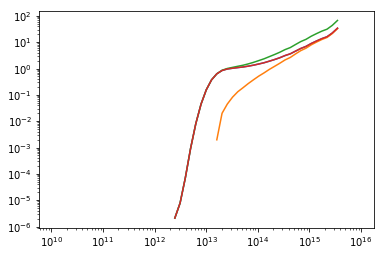

In [67]:
plt.plot(mbc, cen_hod)
plt.plot(mbc, sat_hod)
plt.plot(mbc, cen_hod+sat_hod)
plt.plot(mbc, tot_hod)
plt.loglog();

In [68]:
def ZhengCenHOD(mass, param_dict):
    
    logM = np.log10(mass)
    mean_ncen = 0.5*(1.0 + erf(
        (logM - param_dict['logMmin']) / param_dict['sigma_logM']))

    return mean_ncen

def ZhengSatHOD(mass, param_dict, mean_ncen = None):
    M0 = 10.**param_dict['logM0']
    M1 = 10.**param_dict['logM1']

    mean_nsat = np.zeros_like(mass)

    idx_nonzero = np.where(mass - M0 > 0)[0]
    
    mean_nsat[idx_nonzero] = ((mass[idx_nonzero] - M0)/M1)**param_dict['alpha']

    # If a central occupation model was passed to the constructor,
    # multiply mean_nsat by an overall factor of mean_ncen
    if mean_ncen is not None:
        # compatible with AB models
        mean_nsat *= mean_ncen

    return mean_nsat

def ZhengHOD(mass, param_dict):
    mean_ncen = ZhengCenHOD(mass, param_dict)
    mean_nsat = ZhengSatHOD(mass, param_dict, mean_ncen)
    return mean_ncen, mean_nsat

In [69]:
def calc_nd(mass,param_dict, mass_func):
    cen_hod, sat_hod = ZhengHOD(mass, param_dict)
    hod = cen_hod+sat_hod
    return np.dot(mass_func, hod)/(1000.0**3)

from scipy.optimize import minimize_scalar
def add_logMmin(hod_params, mass, mass_func):

    hod_params['logMmin'] = 13.0 #initial guess
    #cat.populate(hod_params) #may be overkill, but will ensure params are written everywhere
    def func(logMmin, hod_params):
        hod_params.update({'logMmin':logMmin})
        return (calc_nd(mass, hod_params, mass_func) - 5e-4)**2

    res = minimize_scalar(func, bounds = (12,15), args = (hod_params,), options = {'maxiter':100}, method = 'Bounded')

    # assuming this doens't fail
    print 'logMmin', res.x
    hod_params['logMmin'] = res.x

In [70]:
calc_nd(mbc, true_hod_params, mass_func)

0.00048649635535305086

In [30]:
with h5py.File('/u/ki/swmclau2/des/PearceMCMC/HOD_MDPL2_wp_ds_rmin_0.5_HOD.hdf5', 'r') as f:
    hod_pnames =  f.attrs['param_names'][7:-1]
    chain = f['chain'][:, 7:-1]

In [31]:
param_dict = dict(zip(hod_pnames, chain[0]))

In [32]:
add_logMmin(param_dict, mbc, mass_func)

logMmin 13.215872548431053


In [33]:
true_hod_params = {'alpha': 1.083, 'logM0': 13.2, 'logM1': 14.2, 'sigma_logM': 0.2}
true_hod_params['logMmin'] = 13.0 #approx, can fit if i have to

In [34]:
cat = TrainingBox(0)
cat.load(1.0, HOD='zheng07')

In [35]:
def add_logMmin2(cat, params, nd):
    def func(logMmin, hod_params):
        params.update({'logMmin':logMmin})
        return (cat.calc_analytic_nd(params, min_ptcl=20) - nd)**2

    res = minimize_scalar(func, bounds = (12,16), args = (params,), options = {'maxiter':100}, method = 'Bounded')

     # assuming this doens't fail
    print 'logMmin', res.x
    params['logMmin'] = res.x


In [36]:
add_logMmin2(cat, true_hod_params, 5e-4)
cat.populate(true_hod_params)

logMmin 13.13668041816722


In [55]:
print cat.calc_analytic_nd(true_hod_params,min_ptcl=20)

0.0005000001824937846


In [58]:
np.sum(mass_func*cen_hod)/(1000.0**3)

0.000457595

logMmin 13.148201449794596
logMmin 13.119554402620256
logMmin 13.184052788324424
logMmin 13.183954733534119
logMmin 13.164949536672617
logMmin 13.198899876626477
logMmin 13.154760805386308
logMmin 13.116953718463314
logMmin 13.114447241075643
logMmin 13.237657077210862
logMmin 13.222659224239651
logMmin 13.129089585297189
logMmin 13.13617387485246
logMmin 13.172001398102651
logMmin 13.164684995657836
logMmin 13.13331864408366
logMmin 13.136130109032877
logMmin 13.185382289895795
logMmin 13.135631068710516
logMmin 13.168942386560136
logMmin 13.19522524014936
logMmin 13.177066414819599
logMmin 13.192768549485027
logMmin 13.11864860700625
logMmin 13.159653956356706
logMmin 13.138164544312277
logMmin 13.158681616886714
logMmin 13.133126968874874
logMmin 13.118701868364964
logMmin 13.15635330344866
logMmin 13.179968596281816
logMmin 13.174213224729117
logMmin 13.16650603288803
logMmin 13.143374202863411
logMmin 13.178579008573948
logMmin 13.163214427588878
logMmin 13.207098575613738
logMmin

(0.0001, 100.0)

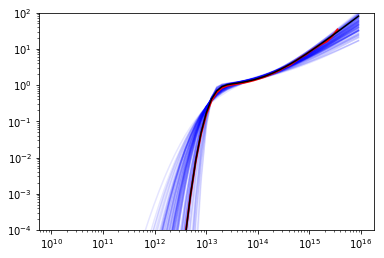

In [38]:
N = 100
idxs = np.random.choice(chain.shape[0], size=N, replace=False)

for i in idxs:
    param_dict = dict(zip(hod_pnames, chain[i]))
    add_logMmin(param_dict, mbc, mass_func)
    c, s = ZhengHOD(mbc, param_dict)
    plt.plot(mbc, c+s, alpha = 0.1, color = 'b')
    
plt.plot(mbc, tot_hod, color = 'r', lw =2)
print '*'*10
#add_logMmin(param)
c,s = ZhengHOD(mbc, true_hod_params)
plt.plot(mbc, c+s, color ='k')
plt.loglog();
plt.ylim([1e-4, 1e2])

In [39]:
catalog = np.load(path.join(um_dir,'hod_catalog3.npy'), allow_pickle=True )

In [40]:
mdpl2_sat_mask = np.ones_like(catalog['gal_type'], dtype=bool)# == 'satellites'

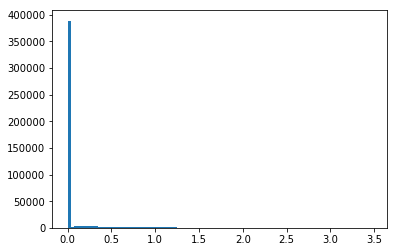

In [41]:
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = 100);

In [42]:
gal_table = cat.model.mock.galaxy_table
sat_mask= np.ones_like(gal_table['gal_type'], dtype = bool)

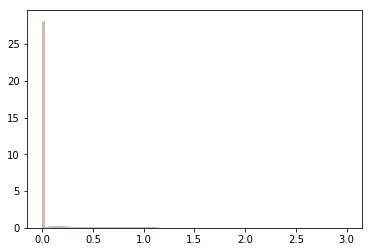

In [43]:
bins = np.linspace(0, 3, 100)
plt.hist(gal_table[sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);
plt.hist(catalog[mdpl2_sat_mask]['host_centric_distance'], bins = bins, alpha = 0.3, normed=True);


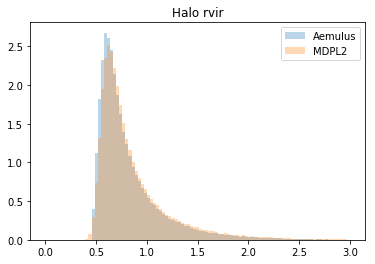

In [44]:
bins = np.linspace(0,3, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('Halo rvir')

In [45]:
mass_bins = np.logspace(12, 16, 4.0/0.1+1)
rvir_perc = np.zeros((len(mass_bins)-1,))
for i, (mb_low, mb_high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
    mass_cut = np.logical_and(mb_low < catalog['halo_mvir'], mb_high > catalog['halo_mvir'])
    cat_at_m = catalog[mass_cut]
    if len(cat_at_m) == 0:
        continue
    rvir_perc[i] = np.percentile(cat_at_m['halo_rvir'], [50])[0]

In [46]:
mass_bins = np.logspace(12, 16, 4.0/0.1+1)
rvir_perc_aemulus = np.zeros((len(mass_bins)-1,))
for i, (mb_low, mb_high) in enumerate(zip(mass_bins[:-1], mass_bins[1:])):
    mass_cut = np.logical_and(mb_low < gal_table['halo_mvir'], mb_high > gal_table['halo_mvir'])
    cat_at_m = gal_table[mass_cut]
    if len(cat_at_m) == 0:
        continue
    rvir_perc_aemulus[i] = np.percentile(cat_at_m['halo_rvir'], [50])[0]

(1.0, 1.2)

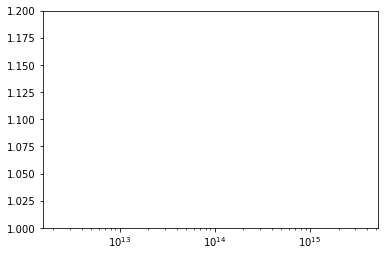

In [47]:
mbc = (mass_bins[1:]+mass_bins[:-1])/2.0
#plt.plot(mbc, rvir_perc)#, yerr = (rvir_perc[:,2]-rvir_perc[:,0])/2 )
plt.plot(mbc, rvir_perc_aemulus/rvir_perc, label ='Aemulus/mdpl2')
plt.xscale('log')
plt.ylim([1.0, 1.2])

In [48]:
import astropy.constants as const
from astropy import units as u
Om0 = 0.341
C = (const.G*const.M_sun/((100*u.km/u.s/u.Mpc)**2))
new_rvir = np.cbrt( C*(gal_table['halo_mvir']/(100*Om0))).to('Mpc').value

In [49]:
new_rvir/gal_table['halo_rvir']#)#, bins = np.linspace(0.9,1.1,11));

0.9995536
0.9995576
0.9995439
0.9995488
0.9995505
0.9995489
0.999551
0.99955285
0.9995439
0.99954665
0.99955225


In [50]:
cat

trainingbox
-------------------------
Halo finder:	 rockstar
Version name:	most_recent_00
Cosmology:
FlatwCDM(H0=63.4 km / (Mpc s), Om0=0.341, w0=-0.817, Tcmb0=0 K, Neff=2.92, m_nu=None, Ob0=0.0565)
Redshifts:	[3.0, 2.003003003003003, 1.0, 0.8499984275013364, 0.7000008500004251, 0.550000697500314, 0.399999440000224, 0.25, 0.09999989000001097, 0.0]
-------------------------
Location:	/nfs/slac/g/ki/ki18/des/swmclau2/NewAemulusBoxes/Box000/halos/m200b/
Lbox:	1050.0
Particle Mass:	39876900000.000000
Columns to Keep:
{'halo_upid': (14, 'i8'), 'halo_vx': (11, 'f4'), 'halo_y': (9, 'f4'), 'halo_x': (8, 'f4'), 'halo_z': (10, 'f4'), 'halo_vy': (12, 'f4'), 'halo_vz': (13, 'f4'), 'halo_rs': (6, 'f4'), 'halo_rvir': (5, 'f4'), 'halo_mvir': (2, 'f4'), 'halo_id': (0, 'i8')}

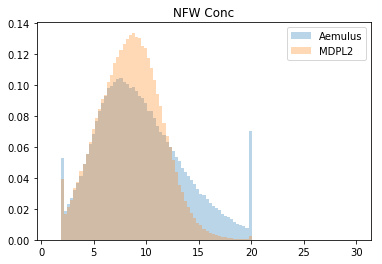

In [51]:
bins = np.linspace(1, 30, 100)
plt.hist(gal_table[sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(1.0*catalog[mdpl2_sat_mask]['conc_NFWmodel'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.title('NFW Conc')

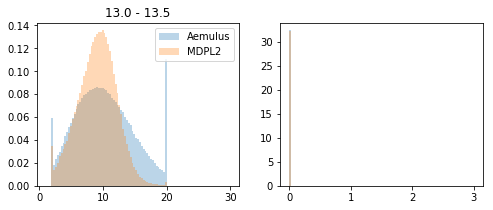

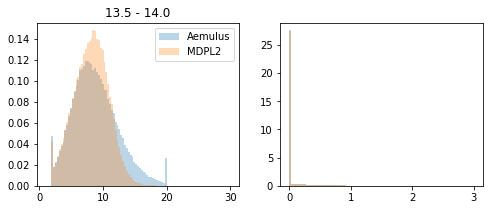

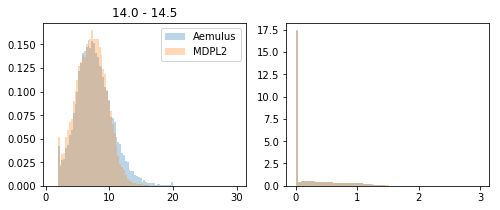

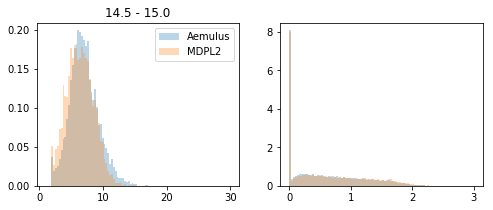

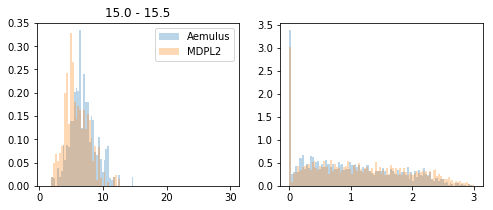

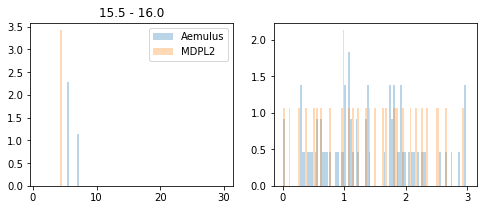

In [52]:
cbins = np.linspace(1, 30, 100)
rbins = np.linspace(0, 3, 100)

haloprop_bins = np.logspace(13,16,7)

for i,(mbl, mbh) in enumerate(zip(haloprop_bins[:-1], haloprop_bins[1:])):
    fig = plt.figure(figsize=(8,3))
    mass_cut = np.logical_and(mbl<gal_table['halo_mvir'], gal_table['halo_mvir']<mbh)
    mask = np.logical_and(mass_cut, sat_mask)
    plt.subplot(121)
    plt.hist(gal_table[mask]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'Aemulus');
    
    mass_cut = np.logical_and(mbl<catalog['halo_mvir'], catalog['halo_mvir']<mbh)
    mask2 = np.logical_and(mass_cut, mdpl2_sat_mask)
    plt.hist(1.0*catalog[mask2]['conc_NFWmodel'], bins = cbins, alpha = 0.3, normed=True, label = 'MDPL2');
    plt.title('%0.1f - %0.1f'%(np.log10(mbl),np.log10(mbh)))
    plt.legend(loc='best')
    plt.subplot(122)
    plt.hist(gal_table[mask]['host_centric_distance'], bins = rbins, alpha = 0.3, normed=True);
    plt.hist(catalog[mask2]['host_centric_distance'], bins = rbins, alpha = 0.3, normed=True);

    plt.show()

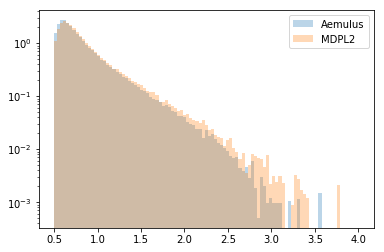

In [53]:
bins = np.linspace(0.5, 4, 100)
plt.hist(gal_table[sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'Aemulus');
plt.hist(catalog[mdpl2_sat_mask]['halo_rvir'], bins = bins, alpha = 0.3, normed=True, label = 'MDPL2');
plt.legend(loc='best')
plt.yscale('log')